The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Average Feature Importance Across Patients (Horizon: 30 min):
------------------------------------------
glucose             :  18.55% ±  2.86%
time                :  13.82% ±  1.55%
glucose_change      :  15.46% ±  3.03%
fats                :   8.21% ±  3.70%
glucose_projected   :  11.80% ±  2.03%
glucose_change_projected:  10.29% ±  2.45%
dietary_fibers      :   5.76% ±  1.97%
proteins            :   5.92% ±  2.89%
complex_sugars      :   4.20% ±  1.03%
simple_sugars       :   4.42% ±  3.42%
insulin             :   1.58% ±  2.06%

Average Feature Importance Across Patients (Horizon: 120 min):
------------------------------------------
glucose             :  18.27% ±  1.79%
time                :  20.08% ±  3.73%
glucose_change      :   8.88% ±  1.38%
fats                :  10.02% ±  2.52%
glucose_projected   :   6.35% ±  1.58%
glucose_change_projected:   7.09% ±  1.07%
dietary_fibers      :   8.80% ±  2.44%
proteins            :   7.36% ±  4.42%
complex_sugars      :   5.55% ±  2.07%

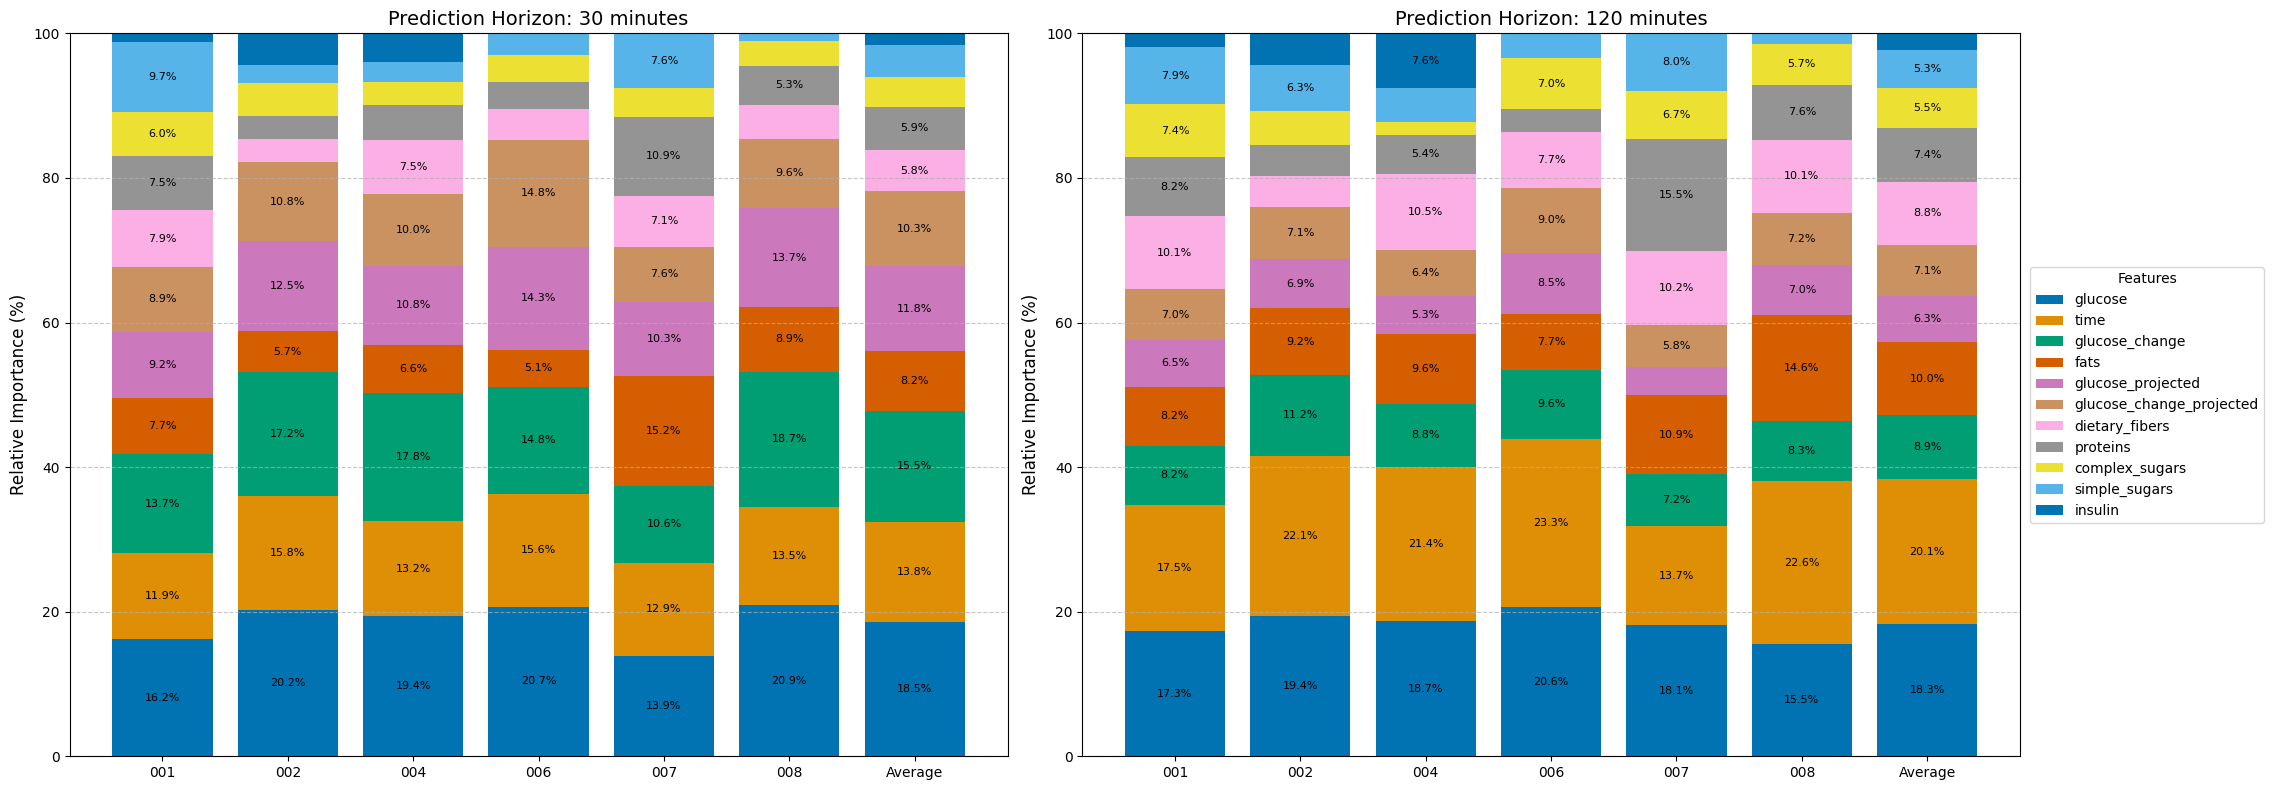

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Constants
patients = ['001', '002', '004', '006', '007', '008']
prediction_horizons = [6, 24]  # 6 = 30 minutes, 12 = 60 minutes

def load_and_process_importances(horizon):
    # Load models and extract importances
    feature_importances = {}
    model_path = f'models/pixtral-large-latest/{horizon}'
    
    for patient in patients:
        model_file = Path(model_path) / f'patient_{patient}_model.pkl'
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
            # Convert to relative importance (sums to 100%)
            importances = model.feature_importances_
            relative_importances = (importances / importances.sum()) * 100
            feature_importances[patient] = dict(zip(model.feature_name_, relative_importances))
    
    return pd.DataFrame(feature_importances)

def plot_relative_importances(df, ax, title, feature_order, colors_dict):
    # Add average column to the dataframe
    df_with_avg = df.copy()
    df_with_avg['Average'] = df.mean(axis=1)
    
    # Reorder features according to the consistent feature_order
    df_with_avg = df_with_avg.reindex(feature_order)
    
    # Create stacked bar plot
    bottom = np.zeros(len(df_with_avg.columns))
    
    for feature in feature_order:
        if feature in df_with_avg.index:
            values = df_with_avg.loc[feature]
            ax.bar(df_with_avg.columns, values, bottom=bottom, label=feature, color=colors_dict[feature])
            bottom += values
    
    # Customize plot
    ax.set_ylabel('Relative Importance (%)', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Add percentage labels inside bars
    for i in range(len(df_with_avg.columns)):
        bottom = 0
        for feature in feature_order:
            if feature in df_with_avg.index:
                value = df_with_avg.loc[feature, df_with_avg.columns[i]]
                if value >= 5:  # Only show labels for features with >5% importance
                    ax.text(i, bottom + value/2, f'{value:.1f}%', 
                            ha='center', va='center', fontsize=8)
                bottom += value
    
    # Add gridlines
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to show percentages
    ax.set_ylim(0, 100)

def plot_average_importances(df, ax, title):
    # Calculate average importance across patients
    avg_importance = df.mean(axis=1)
    
    # Sort by importance
    avg_importance = avg_importance.sort_values(ascending=False)
    
    # Use a color-blind friendly palette
    colors = sns.color_palette("colorblind", len(avg_importance))
    
    # Create horizontal bar plot
    bars = ax.barh(avg_importance.index, avg_importance, color=colors)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', va='center')
    
    # Customize plot
    ax.set_xlabel('Average Relative Importance (%)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.set_xlim(0, max(avg_importance) * 1.1)  # Add some space for labels

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# First, load all importances to determine a consistent feature order
all_importances = []
for horizon in prediction_horizons:
    importances_df = load_and_process_importances(horizon)
    all_importances.append(importances_df)

# Combine all features from both horizons
all_features = set()
for df in all_importances:
    all_features.update(df.index)

# Create a consistent feature order based on average importance across all horizons
combined_avg = pd.DataFrame()
for i, df in enumerate(all_importances):
    avg_importance = df.mean(axis=1)
    combined_avg[f'horizon_{prediction_horizons[i]}'] = avg_importance

# Fill NaN values with 0 (features not present in some horizons)
combined_avg = combined_avg.fillna(0)
# Calculate overall average importance
combined_avg['overall_avg'] = combined_avg.mean(axis=1)
# Sort by overall average importance
consistent_feature_order = combined_avg.sort_values('overall_avg', ascending=False).index.tolist()

# Create a consistent color mapping
colors = sns.color_palette("colorblind", len(consistent_feature_order))
color_mapping = {feature: colors[i] for i, feature in enumerate(consistent_feature_order)}

# Process and plot for each prediction horizon
for i, horizon in enumerate(prediction_horizons):
    # Get feature importances
    importances_df = all_importances[i]
    
    # Create stacked bar plot with consistent feature order and colors
    title = f'Prediction Horizon: {horizon*5} minutes'
    plot_relative_importances(importances_df, axes[i], title, consistent_feature_order, color_mapping)
    
    # Print summary statistics
    print(f"\nAverage Feature Importance Across Patients (Horizon: {horizon*5} min):")
    print("------------------------------------------")
    mean_importance = importances_df.mean(axis=1)
    std_importance = importances_df.std(axis=1)
    for feature in consistent_feature_order:
        if feature in mean_importance.index:
            print(f"{feature:20s}: {mean_importance[feature]:6.2f}% ± {std_importance[feature]:5.2f}%")

# Add a single legend for the stacked bar plots
# Create custom legend handles and labels based on the consistent feature order
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_mapping[feature], label=feature) 
                  for feature in consistent_feature_order]

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.845, 0.5),
           fontsize=10, title='Features')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for the legend

plt.savefig('images/results/feature_importances.eps', dpi=300)
plt.show()

In [5]:
importances_df

,001,002,004,006,007,008
glucose,17.279467,19.442705,18.674325,20.648240,18.097754,15.483773
time,17.461038,22.103945,21.359826,23.280684,13.712021,22.565969
glucose_change,8.200938,11.239825,8.755045,9.559065,7.212682,8.340916
glucose_change_projected,7.005598,7.122730,6.380006,8.966765,5.785997,7.249014
glucose_projected,6.476018,6.903569,5.262341,8.538993,3.936592,6.960874
simple_sugars,7.883190,6.293049,4.641416,3.455084,8.005284,1.425538
complex_sugars,7.368740,4.821540,1.769637,6.992432,6.657860,5.686988
fats,8.185807,9.157796,9.639863,7.650543,10.885073,14.604186
dietary_fibers,10.062037,4.289292,10.478112,7.683449,10.198151,10.100091
proteins,8.155545,4.226675,5.433095,3.224745,15.508587,7.582651
